# Modelación para la predicción salarial. 

**Equipo 9**

**Integrantes:**
    
+ **Wendy Areli Ramírez Burgos**
+ **Gustavo Corona Ojeda**
+ **Carlos Fernando Vásquez Guerra**

En los últimos años, el ejercicio profesional de la ciencia de datos, se ha presentado como un campo de gran importancia para el crecimiento de las compañías y de la ciencia, por lo que el requerimiento de éstos perfiles ha ido en aumento, siendo una de las profesiones emergentes más importantes en los últimos 4 años; sin embargo, aproximadamente el 9% de las vacantes disponibles quedan sin cubrir por falta de perfiles especializados, lo que contribuye a que sea una de las profesiones mejor pagadas. A éste respecto, el sueldo promedio para E,U se encuentra en los 120, 000 dólares anuales; siendo además el país con más alta demanda de científicos de datos. En estudios anteriores se ha encontrado además, que los sueldos en primedio se encuentran por encima del promedio nacional, en países de América, Europa , Asia y América latina. Si bien los requerimientos especificados por cada empresa son diversos, el manejo de lenguajes como Python y R se mantienen como los más populares en el mercado Latinoamericano

En este documento se desgloza todo el análisis de datos que realizamos con la finalidad de estimar y predecir el salario promedio de las ofertas laborales en el mercado de glassdor.

In [1]:
#Basics
import warnings
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Natural language processing
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

#Models
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

#Rendimiento - evaluación
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression

#Setings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

Comenzamos cargando nuesto conjunto de datos

In [2]:
jobs = pd.read_csv("final_jobs_dataScience.csv")

In [3]:
jobs.head(3)

,Puesto laboral,Empresa,Estado,Ciudad,Salario mínimo,Salario máximo,Tipo de moneda,Descripción,Giro de la empresa,Fecha de publicación,Vigencia de la oferta,País,Esquema de pago,Cantidad de lenguajes requeridos,Título ofrecido,Requerimiento educación,Salario promedio,Lenguajes de programación/tecnologías requeridas,Modalidad,Estudios previos,Experiencia (Años),Habilidades blandas,Idiomas
0,Data Engineer with Azure Synapse,4urHires INC,not specified,not specified,8800.0000,9600.0000,USD,Azure Engineer Strong experience in SynapseJob...,not specified,2022-09-16,2022-10-16,EUA,hour,2,Not specified,1,9200.0000,"azure,synapse",remoto,"azure engeneer,",10.0000,not specified,not specified
1,Data Engineer,MARS Group,not specified,not specified,6348.8000,9600.0000,USD,Description: Data is a critical driver of this...,not specified,2022-09-14,2022-10-16,EUA,hour,5,Not specified,1,7974.4000,"java,scala,aws,docker,kubernetes",remoto,"b.s. degree in computer science or related field,",2.0000,"ability to adapt and learn new technologies, ...",not specified
2,Data Engineer - ENTRY LEVEL,PCS Global Tech,California,Los Angeles,5000.0000,5833.3333,USD,Responsibilities· Analyze and organize raw dat...,Tecnologías de la información,2022-09-15,2022-10-16,EUA,year,3,Junior,1,5416.6667,"java,python,sql",híbrido,"degree in computer science, it, or similar fie...",0.0000,"collaborate,",not specified


Ya se ha realizado en fases anteriores un análisis descriptivo del conjunto de datos, pero es importante mencionar de manera rápida la configuración de nuestro conjunto de datos

In [4]:
jobs.shape

(506, 23)

Contamos con 506 observaciones donde nuestra unidad muestral son diversas ofertas laborales publicadas en la página [glassdoor](https://www.glassdoor.com.mx/member/home/index.htm), las cuales fueron obtenidas mediante técnicas de web scrapping, consiguiendo la siguiente estructura de nuestro conjunto de datos:

+ Puesto laboral: Título del puesto laboral publicado.
+ Empresa: Empresa que publicó la oferta laboral.
+ Estado: Estado donde se indica la oferta laboral.
+ Ciudad: Ciudad donde se indica la oferta laboral.
+ Salario mínimo: Salario mínimo basado en el rango salarial que se indica en la oferta laboral en dolares.
+ Salario máximo: Salario máximo basado en el rango salarial que se indica en la oferta laboral en dolares.
+ Tipo de moneda: Tipo de moneda a la cual se pagará en la oferta laboral.
+ Descripción: Descripción de la oferta laboral.
+ Giro de la empresa: Giro de la empresa que publicó la oferta laboral.
+ Fecha de publicación: Fecha de publicación de la oferta laboral.
+ Vigencia de la oferta: Fecha de vigencia de la oferta laboral.
+ País: País donde se indica la oferta laboral.
+ Esquema de pago: Temporalidad a la que se presenta el rango salarial (hora, mes, etc.).
+ Cantidad de lenguajes requeridos: Número de lenguajes de programación o herramientas de software mencionados en la oferta laboral.
+ Título ofrecido: Junior, Senior, etc.
+ Requerimiento educación: ¿Se menciona algún grado escolar en la oferta laboral?
+ Salario promedio (**variable a predecir**): Salario promedio de la oferta laboral en dolares.
+ Lenguajes de programación/tecnologías requeridas: Lenguajes de programación o herramientas de software mencionados en la oferta laboral.
+ Modalidad: Modalidad en la que se trabajará (remoto, híbrido, presencial o sin especificar).
+ Estudios previos: Descripción de los grados y titulos escolares solicitados.
+ Experiencia (Años) : Experiencia requerida para postular en la oferta laboral.
+ Habilidades blandas: Habilidades blandas mencionadas en la descripción de la oferta laboral.
+ Idiomas: Idiomas requeridos en la oferta laboral.

Respecto a la variable de salario promedio (nuestro target) tenemos la siguiente distribución:

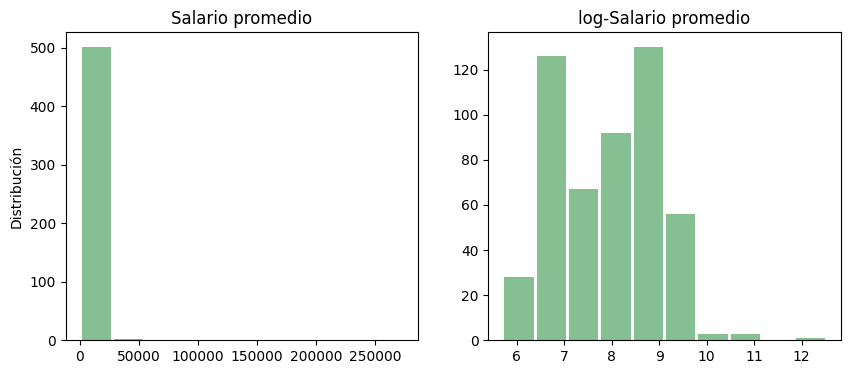

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
jobs["Salario promedio"].hist(ax = ax[0], grid=False, color='#86bf91', rwidth=0.9).set(title='Salario promedio', ylabel='Distribución')
jobs["Salario promedio"].map(np.log).hist(ax = ax[1], grid=False, color='#86bf91', rwidth=0.9).set(title='log-Salario promedio', ylabel='')
plt.show()

Tenemos que notar dos cosas de las gráficas anteriores: 

1. Tenemos una distribución asimétrica en los salarios, con una cola pesada. El logaritmo nos ayudará a tener una mejor distribución del salario promedio.
2. Considerando la transformación logarítmica, se pueden notar una distribución bimodal, lo cual puede perjudicar a la modelación.

Por el último punto, se realizaron modelos separados de regresión por la variable del país, considerando un modelo para el caso de México y otro para Estados Unidos y Canadá juntos ya que esta variable es la que hace que existan dos modas, como se puede apreciar en la siguiente gráfica

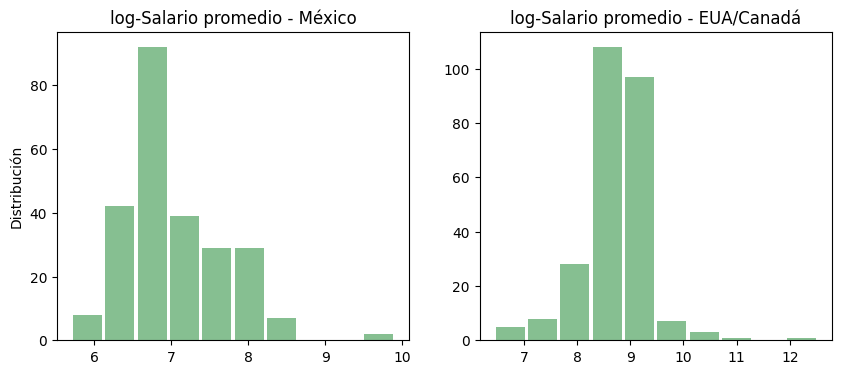

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
jobs[jobs["País"] == "MX"]["Salario promedio"].map(np.log).hist(ax = ax[0], grid=False, color='#86bf91', rwidth=0.9).set(title='log-Salario promedio - México', ylabel='Distribución')
jobs[jobs["País"] != "MX"]["Salario promedio"].map(np.log).hist(ax = ax[1], grid=False, color='#86bf91', rwidth=0.9).set(title='log-Salario promedio - EUA/Canadá', ylabel='')
plt.show()

Lo siguiente es el proceso que se realizó para la modelación del salario promedio para México y para Estados Unidos junto con Canadá. Previo a esto, presentamos algunos ajustes de codificación extra que ayudan al modelado de la información.

Creamos algunas funciones para mejorar la codificación de algunas variables categóricas

In [7]:
def append_language(idioma, pais):
    if(idioma == "not specified"):
        if pais == "MX":
            return "Español"
        else:
            return "Inglés"
    else:
        return idioma

jobs["Idiomas"] = jobs.apply(lambda x: append_language(x["Idiomas"], x["País"]),axis = 1)

In [8]:
def fix_language(idioma):
    if(idioma == "Inglés avanzado/fluido" or idioma == "Bilingüe" or idioma == "Inglés avanzado"):
        return "Inglés avanzado/bilingüe"
    if(idioma == "Inglés intermedio" or idioma == "Inglés" or idioma == "Inglés básico" or idioma == "Inglés intermedio/avanzado"):
        return "Inglés"
    return idioma
jobs["Idiomas"] = jobs.apply(lambda x: fix_language(x["Idiomas"]),axis = 1)

In [9]:
def fix_Estado(modalidad, estado):
    if(modalidad == "remoto"):
        return "remoto"
    else:
        return estado
jobs["Estado"] = jobs.apply(lambda x: fix_Estado(x["Modalidad"], x["Estado"]),axis = 1)
jobs["Estado"] = jobs["Estado"].map(lambda x: "México" if x == "not specified" else x)

### Caso: México

In [10]:
jobs_MX = jobs[jobs["País"] == "MX"]
jobs_MX.reset_index(drop = True, inplace = True)

Vamos a comenzar dividiendo nuestros datos

In [11]:
X_train, X_test, y_train, y_test = train_test_split(jobs_MX.drop("Salario promedio", axis = 1), jobs_MX["Salario promedio"], test_size=0.20, random_state=31)

Ahora, vamos a realizar algunos métodos de procesamiento de lenguaje natural para obtener las palabras más repetidas sobre las habilidades blandas y en la variable donde se describe la oferta laboral

In [12]:
#Omitimos donde no se describen las habilidades blandas
habilidades_blandas = X_train["Habilidades blandas"][X_train["Habilidades blandas"] != "not specified"].copy()

#Hacemos limpieza previa del texto:
habilidades_blandas = habilidades_blandas.str.replace(",|\.|\;|\:|\+|·", " ", regex=True)
habilidades_blandas = habilidades_blandas.str.lower()
habilidades_blandas = habilidades_blandas.str.strip()
habilidades_blandas = habilidades_blandas.str.replace('[^\w\s]', '')
habilidades_blandas = habilidades_blandas.str.replace('\d', '')
habilidades_blandas = habilidades_blandas.str.replace('\\n', '')
habilidades_blandas = habilidades_blandas.dropna()

In [13]:
# Separamos cada oración en palabras
tokenized = habilidades_blandas.apply(nltk.word_tokenize)
# Sumamos todas las listas para obtener una lista con todas las palabras en nuestro conjunto de datos
all_words = tokenized.sum()
text = nltk.Text(all_words)

In [14]:
#Retiramos las stopwords de cada idioma y obtenemos una frecuencia de cada palabra relevante
all_words = tokenized.sum()
english_stop_words = stopwords.words('english')
spanish_stop_words = stopwords.words('spanish')
all_words_except_stop_words = [word for word in all_words if word not in english_stop_words]
all_words_except_stop_words = [word for word in all_words_except_stop_words if word not in spanish_stop_words]
freq_dist = nltk.FreqDist(all_words_except_stop_words)

La siguiente visualización muestra las palabras más repetidas respecto a las habilidades blandas en las ofertas laborales

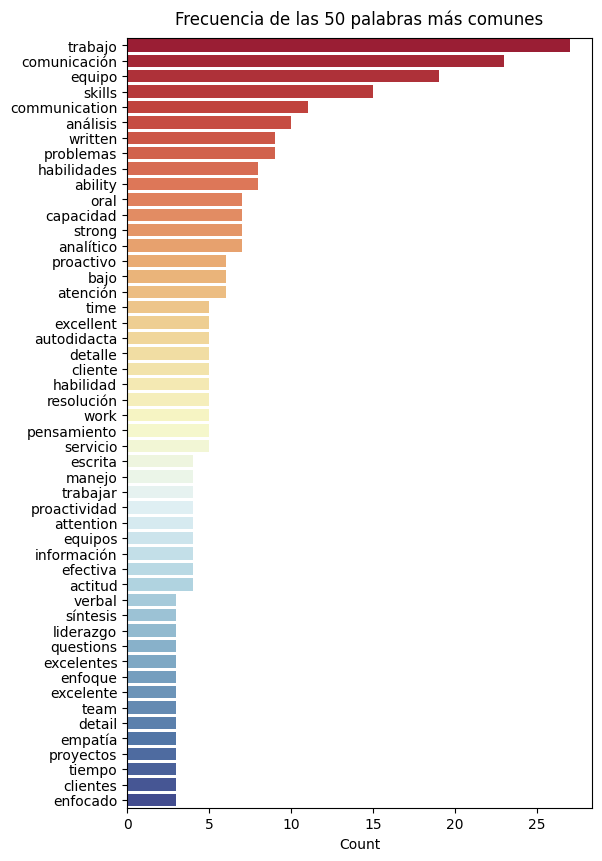

In [15]:
most_common_50 = np.array(list(map(lambda x: list(x), freq_dist.most_common(50))))

fig = plt.figure(figsize=(6, 10))
ax = fig.add_subplot()

sns.barplot(y = most_common_50[:, 0], x= [eval(i) for i in list(most_common_50[:, 1])], ax=ax, palette='RdYlBu', orient='h');
ax.set_title('Frecuencia de las 50 palabras más comunes', pad=10)
ax.set_xlabel('Count');

Lo anterior nos permite visualizar los anteriores resultados en una nube de palabras como la siguiente:

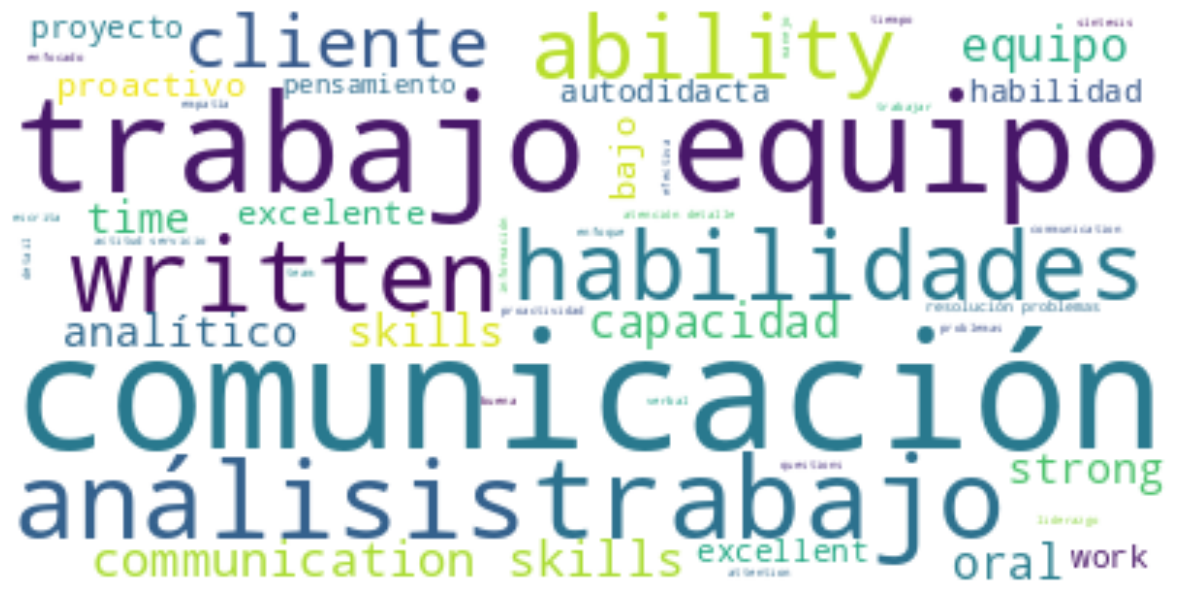

In [16]:
wordcloud = WordCloud(max_font_size=100, background_color="white").generate(' '.join(all_words_except_stop_words))

plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Para determinar las habilidades blandas más solicitadas, tomamos las primeras 10 palabras más comunes en nuestro conjunto de datos agrupando aquellas similares y que son distintas por el idioma

In [17]:
# most_common_50[0:18]

Con la anterior, vamos a crear variables indicadoras que representen si en la variable de habilidades blandas se mencionan las siguientes palabras clave:

+ work/trabajo
+ comunication/comunicación
+ team/equipo
+ análisis/analítico
+ skills
+ written
+ ability/habilidades
+ verbal/oral
+ strong
+ proactivo

Hacemos el mismo proceso con la variable de la descripción

In [18]:
Desc_laborales = X_train["Descripción"][X_train["Descripción"] != "not specified"].copy()

#Hacemos limpieza previa del texto:
Desc_laborales = Desc_laborales.str.replace(",|\.|\;|\:|\+|·", " ", regex=True)
Desc_laborales = Desc_laborales.str.lower()
Desc_laborales = Desc_laborales.str.strip()
Desc_laborales = Desc_laborales.str.replace('[^\w\s]', '')
Desc_laborales = Desc_laborales.str.replace('\d', '')
Desc_laborales = Desc_laborales.str.replace('\\n', '')
Desc_laborales = Desc_laborales.dropna()

In [19]:
# Separamos cada oración en palabras
tokenized = Desc_laborales.apply(nltk.word_tokenize)
# Sumamos todas las listas para obtener una lista con todas las palabras en nuestro conjunto de datos
all_words = tokenized.sum()
text = nltk.Text(all_words)

In [20]:
all_words = tokenized.sum()
english_stop_words = stopwords.words('english')
spanish_stop_words = stopwords.words('spanish')
all_words_except_stop_words = [word for word in all_words if word not in english_stop_words]
all_words_except_stop_words = [word for word in all_words_except_stop_words if word not in spanish_stop_words]
freq_dist = nltk.FreqDist(all_words_except_stop_words)

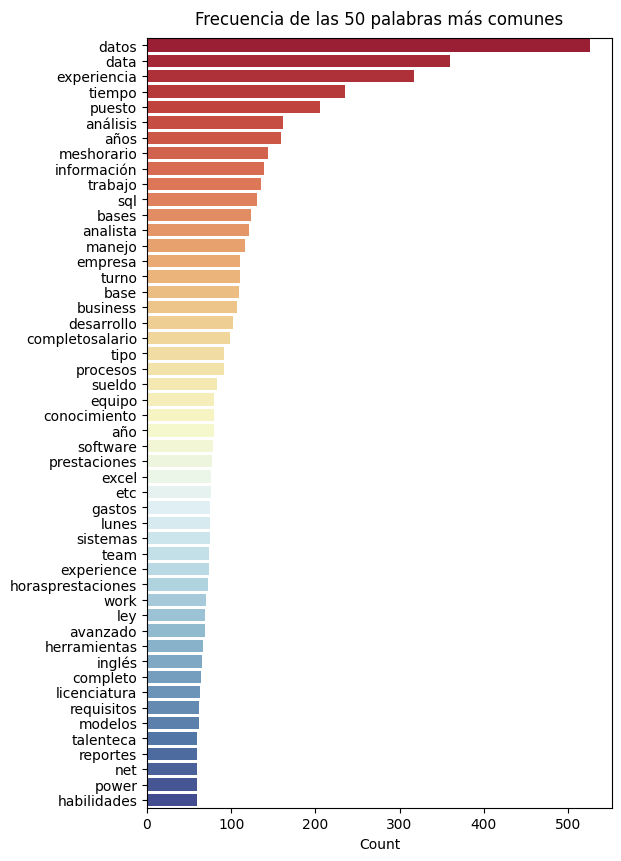

In [21]:
most_common_50 = np.array(list(map(lambda x: list(x), freq_dist.most_common(50))))

fig = plt.figure(figsize=(6, 10))
ax = fig.add_subplot()

sns.barplot(y = most_common_50[:, 0], x= [eval(i) for i in list(most_common_50[:, 1])], ax=ax, palette='RdYlBu', orient='h');
ax.set_title('Frecuencia de las 50 palabras más comunes', pad=10)
ax.set_xlabel('Count');

In [22]:
#most_common_50[0:17]

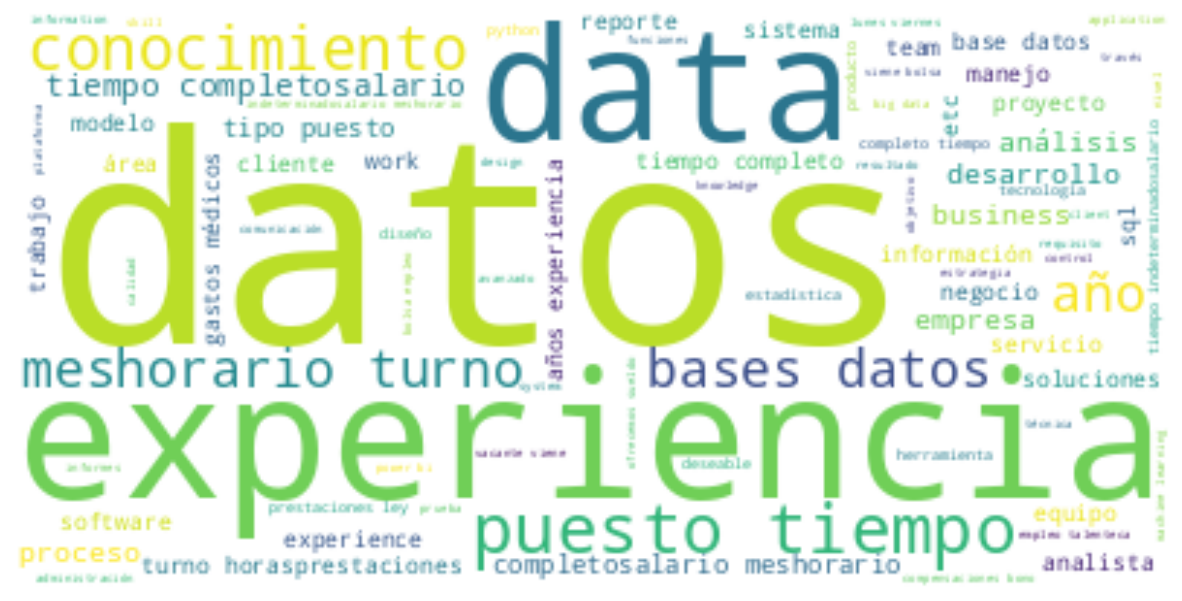

In [23]:
wordcloud = WordCloud(max_font_size=100, background_color="white").generate(' '.join(all_words_except_stop_words))

plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Gracias a lo anterior, sabemos que en nuestros datos de entrenamiento tenemos una gran presencia de las siguientes palabras de la descripción:

+ data/datos
+ experience/experiencia
+ tiempo/años/years
+ puesto
+ análisis/analista
+ información/information
+ work/trabajo
+ bases/base
+ business
+ development/desarollo

Ahora, ya que tenemos identificadas las palabras relevantes, vamos a obtener nuestras nuevas columnas indicadoras

Además, obtendremos información relevante de otras variables

In [24]:
#funciones auxiliares:
def search_in_list(pattern, lista):
    for i in lista:
        if bool(re.search(pattern,i)):
            return True
    return False

def check_string(something):
    if isinstance(something, str):
        if len(something)>0:
            return something
        else: return " "
    else:
        return " "

""" Función para obtener las herramientas de software más importantes 
"""
def dummy_lenguageProgramming(data_original):
    data = data_original.copy()
    aux_dict = {".*sql.*":"sql",
            "^jupyter$": "python", "^matplotlib$":"python", "^tensorflow$":"python", "^scikit learn$": "python", "^scikitimage$": "python", "^seaborn$": "python", "^numpy$": "python", "^pandas$": "python","^py\w+": "python",
            "^excel$":"excel/vba", "^vba$":"excel/vba",
            "^ggplot$":"r", "^rstudio$":"r", 
            "^microsoft$": "microsoft/office", "^powerpoint$":"microsoft/office", "^word$":"microsoft/office",
            "^power bi$":"power bi",
            "^azure.+":"azure",
            "^apache.+":"apache",
            "^tableau.+":"tableau",
            "^aws.+": "aws",
            "^c$":"c/c#/c++", "^c#$":"c/c#/c++", "^c\+\+$":"c/c#/c++",
            "^java$":"java",
            "^javascript$":"javascript",
            "^oracle$": "oracle", 
            "^google.+": "google", 
            "^sas$": "sas",
            "^spark$": "spark",
            "^hadoop$": "hadoop"}

    #Creamos las variables
    for i in list(set(aux_dict.values())):
        data[i] = 0

    #Ahora, hacemos las identificaciones:
    for i in aux_dict.keys():
        data[aux_dict[i]] = data[aux_dict[i]] + data["Lenguajes de programación/tecnologías requeridas"].map(lambda x: search_in_list(i, check_string(x).split(",")))

    #Arreglamos cuando hubieron duplicados:
    for i in list(set(aux_dict.values())):
        data[i] = data[i].map(lambda x: 1 if x > 1 else x)
    
    return data

""" Función para obtener las carreras más importantes 
"""

def dummy_school(data_original):
    data = data_original.copy()
    relevant_carrers = {"licenciatura": "licenciatura", "lic\.": "licenciatura", "bachelor":"licenciatura",
                       "maest": "maestría", "master": "maestría", "docto":"doctorado/postdoctorado", 
                       "trun": "carrera trunca/bachillerato", "bachill": "carrera trunca/bachillerato"}
    scholar_grade = {"estad": "estadística", "stati": "estadística", 
                     "datos":"ciencia/ingienería de datos", "data": "ciencia/ingienería de datos",
                    "finanz": "finanzas", "financ": "finanzas","econo": "economía", 
                    "negocios":"business", "business": "business",
                    "mate": "matemáticas", "math":"matemáticas","comput": "computación",
                    "física": "física", "phy": "física", "inge": "ingeniería", "engi": "ingeniería",
                    "bio": "biology/bioinformatics/etc.",
                    "actua": "actuaría"}

#Creamos las variables
    for i in list(set(relevant_carrers.values())):
        data[i] = 0
    for i in list(set(scholar_grade.values())):
        data[i] = 0
        
    #Ahora, hacemos las identificaciones:
    for i in relevant_carrers.keys():
        data[relevant_carrers[i]] = data[relevant_carrers[i]] + data["Estudios previos"].map(lambda x: bool(re.search(i,check_string(x))))
    for i in scholar_grade.keys():
        data[scholar_grade[i]] = data[scholar_grade[i]] + data["Estudios previos"].map(lambda x: bool(re.search(i,check_string(x))))

        #Arreglamos cuando hubieron duplicados:
    for i in list(set(relevant_carrers.values())):
        data[i] = data[i].map(lambda x: 1 if x > 1 else x)
        
        #Arreglamos cuando hubieron duplicados:
    for i in list(set(scholar_grade.values())):
        data[i] = data[i].map(lambda x: 1 if x > 1 else x)
    
    return data

""" Función para obtener los términos más importantes para las habilidades blandas y la descripción
"""
def most_words_description(data_original):
    data = data_original.copy()
    description_dict = {"data" : "data/datos",
                        "datos" : "data/datos",
                        "experiencia" : "experience/experiencia",
                        "experience" : "experience/experiencia",
                        "tiempo" : "tiempo/años/years",
                        "años" : "tiempo/años/years",
                        "years" : "tiempo/años/years",
                        "work" : "work/working",
                        "puesto" : "puesto",
                        "análisis": "análisis/analista",
                        "analista": "análisis/analista",
                        "información" : "información/information",
                        "information" : "información/information",
                        "work" : "work/trabajo",
                        "trabajo" : "work/trabajo",
                        "bases" : "bases/base",
                        "base" : "bases/base",
                        "business" : "business",
                        "development" : "development/desarollo",
                        "desarollo" : "development/desarollo"}
    blandas_dict = {"work" : "work/trabajo",
                    "trabajo" : "work/trabajo",
                    "communication" : "communication/comunicación",
                    "comunicación" : "communication/comunicación",
                    "team" : "team/equipo",
                    "equipo" : "team/equipo",
                    "análisis" : "análisis/analítico",
                    "analítico" : "análisis/analítico",
                    "skills" : "skills",
                    "written" : "written",
                    "ability" : "ability/habilidades",
                    "habilidades" : "ability/habilidades", 
                    "verbal/oral" : "verbal/oral",
                    "oral" : "verbal/oral",
                    "strong" : "strong",
                    "proactivo" : "proactivo"}

#Creamos las variables
    for i in list(set(description_dict.values())):
        data[i] = 0
    for i in list(set(blandas_dict.values())):
        data[i] = 0
        
    #Ahora, hacemos las identificaciones:
    for i in description_dict.keys():
        data[description_dict[i]] = data[description_dict[i]] + data["Descripción"].map(lambda x: bool(re.search(i,check_string(x))))
    for i in blandas_dict.keys():
        data[blandas_dict[i]] = data[blandas_dict[i]] + data["Habilidades blandas"].map(lambda x: bool(re.search(i,check_string(x))))

    for i in list(set(description_dict.values())):
        data[i] = data[i].map(lambda x: 1 if x > 1 else x)
    for i in list(set(blandas_dict.values())):
        data[i] = data[i].map(lambda x: 1 if x > 1 else x)
    
    return data

Y ahora, aplicamos las anteriores trasnformaciones a nuestros conjuntos de datos

In [25]:
X_train = dummy_lenguageProgramming(X_train)
X_train = dummy_school(X_train)

X_test = dummy_lenguageProgramming(X_test)
X_test = dummy_school(X_test)

In [26]:
X_train = most_words_description(X_train)

X_test = most_words_description(X_test)

Ya que obtuvimos la información relevante de algunas variables, vamos a eliminar las variables que utilizamos para extraer la información y también removemos otras que no son de nuestro interés ya que deseamos entender el comportamiento de las ofertas laborales sin caracteríscas como: El nombre del puesto laboral, la empresa, la fecha de publicación", la vigencia de la oferta

In [27]:
X_train.drop(["Puesto laboral", "Empresa", "Salario mínimo", "Salario máximo", "Descripción","Fecha de publicación","Vigencia de la oferta", "Estudios previos" ,"Habilidades blandas", "Lenguajes de programación/tecnologías requeridas"], axis = 1, inplace=True)
#Eliminamos la variable `Giro de la empresa` ya que en pasos posteriores, la agrupación de categorías relevantes hacía que esta variable no diera información importante. 
X_train.drop(["Giro de la empresa"], inplace=True, axis = 1)

Vamos a imputar el valor promedio a la variable de los años de experiencia

In [28]:
X_train = X_train.fillna(value = {"Experiencia (Años) ":X_train["Experiencia (Años) "].mean()})
X_test = X_test.fillna(value = {"Experiencia (Años) ":X_test["Experiencia (Años) "].mean()})

Identificamos aquellas variables categóricas y numéricas que queremos tratar previo a la aplicación de modelos

In [29]:
cat_cols = ['Estado', "Tipo de moneda", 'Ciudad',"Idiomas", "Título ofrecido", "País", "Esquema de pago", "Modalidad"]
num_cols = ['Cantidad de lenguajes requeridos', "Experiencia (Años) "]
target = "Salario promedio"

Ahora, normalicemos categorías para que, al momento de obtener las variables indicadoras por el método OneHotEncoder, solo cree variables con categórias que tengan una presencia significativa en la información.

In [30]:
def normalize(df, features):
    for feature in features:
        aux = df[feature].value_counts(True)
        ls_categories = [category for category, freq in aux.items() if freq > 0.05]
        df[feature] = df[feature].map(lambda x: x if x in ls_categories else "Others")
    return df

In [31]:
X_train = normalize(X_train, cat_cols)
X_test = normalize(X_test, cat_cols)

Vamos a identificar y eliminar outliers, véase que si removemos esto, retenemos el 94% de la información:

In [32]:
def detect_outlier(serie, method):
    if method == "iqr":
        q1 = serie.quantile(.25)
        q3 = serie.quantile(.75)
        iqr = q3-q1
        upper_fence = q3 + 1.5*iqr
        lower_fence = q1 - 1.5*iqr
    return ~serie.between(lower_fence, upper_fence, inclusive="both")

Xq = pd.concat(map(lambda column: detect_outlier(X_train[column], "iqr").rename(f"{column}_ol"), X_train[num_cols].columns), axis=1)
shape_old = X_train.shape
shape_new_qr = Xq[Xq.mean(axis=1)<=.4].shape
print(shape_new_qr[0]/shape_old[0])

0.9393939393939394


Así que removemos dichos valores extremos

In [33]:
out_index = Xq[Xq.mean(axis=1)>0.4].index
X_train = X_train[[i not in out_index for i in X_train.index]]
y_train = y_train[[i not in out_index for i in y_train.index]]

Estos valores que fueron removidos, fueron por una gran cantidad de lenguajes o software que se solicita en la oferta laboral o por solicitar una gran cantidad de años de experiencia

In [34]:
jobs.iloc[list(out_index)]

,Puesto laboral,Empresa,Estado,Ciudad,Salario mínimo,Salario máximo,Tipo de moneda,Descripción,Giro de la empresa,Fecha de publicación,Vigencia de la oferta,País,Esquema de pago,Cantidad de lenguajes requeridos,Título ofrecido,Requerimiento educación,Salario promedio,Lenguajes de programación/tecnologías requeridas,Modalidad,Estudios previos,Experiencia (Años),Habilidades blandas,Idiomas
164,Senior Vue/Node engineer,LION SYSTEMS SOLUTIONS,remoto,not specified,2300.0000,2500.0000,MXN,DescriptionStaff/Principal Software EngineerLo...,not specified,2022-09-05,2022-10-16,MX,month,9,Senior,0,2400.0000,"node.js,vue,postgresql,redis,google cloud plat...",remoto,not specified,7.0000,not specified,Inglés
184,Analista de Planeación Financiera,SISTEMAS INTEGRALES KANTO,México,Ciudad de México,850.0000,920.0000,MXN,Somos una empresa que cree en los valores de i...,not specified,2022-08-19,2022-10-16,MX,month,2,Not specified,1,885.0000,"tableau,excel",not specified,"licenciatura en finanzas, contabilidad, actuar...",1.0000,"planeación, organización, análisis y síntesis...",Español
22,Data Engineer,Brik Partners,México,not specified,12800.0000,14400.0000,USD,ResponsibilitiesAnalyze and organize raw dataB...,not specified,2022-08-22,2022-10-16,EUA,hour,4,Not specified,1,13600.0000,"azure data lake,python,teradata,sql",not specified,"degree in computer science, it, or similar fie...",3.0000,not specified,Inglés
173,DevOps Engineer Bilingue Mérida,Reclutamiento IT,Baja California,Tijuana,3250.0000,3750.0000,MXN,Esta vacante viene de la bolsa de empleo Talen...,not specified,2022-09-13,2022-10-16,MX,month,12,Not specified,0,3500.0000,"c#,asp.net,mvcrazor5,.net,java,azure,sql serve...",presencial,not specified,4.0000,not specified,Inglés
197,ANALISTA JR,ENNOVASOFT,Chiapas,Tapachula,300.0000,NaN,MXN,"Analista jrResponsable de definir, gestionar y...",not specified,2022-08-22,2022-10-16,MX,month,13,Junior,1,300.0000,"java,php,sql,javascript,microsoft office,mysql...",híbrido,"ing. en sistemas.experiencia,",0.0000,not specified,Español
189,Analista Jr de Análisis de Información Comercial,El Puerto de Liverpool,México,not specified,350.0000,NaN,MXN,Descripción empresa:\nEl Puerto de Liverpool e...,Ventas al mayoreo y al menudeo,2022-09-04,2022-10-16,MX,month,2,Junior,1,350.0000,"excel,sap",híbrido,"lic. actuaría, lic. en sistemas, lic. en infor...",2.0000,not specified,Inglés
49,Data Scientist/Big Data Analyst,PRISMITCORP,Texas,Austin,8000.0000,9600.0000,USD,Data Scientist / Big Data SpecialistLocation- ...,Tecnologías de la información,2022-08-24,2022-10-16,EUA,hour,13,Not specified,0,8800.0000,"elastic,cloudera,apache nifi,kafka,hadoop,kust...",presencial,not specified,3.0000,not specified,Inglés
188,Analista Workforce Jr,Totalplay,México,Ciudad de México,750.0000,850.0000,MXN,"TOTALPLAY ESTA EN BUSCA DE TÚ TALENTO, SOLICIT...",not specified,2022-09-04,2022-10-16,MX,month,1,Junior,1,800.0000,excel,not specified,"bachillerato concluido o lic. trunca ,",1.0000,not specified,Español
163,Administrador de Base de Datos SR SQL,Trejo & Asociados,México,not specified,2750.0000,3500.0000,MXN,Empresa Financiera solicita: Administrador de ...,not specified,2022-08-29,2022-10-16,MX,month,5,Senior,0,3125.0000,"sql server,mysql,sql cloud,azure,aws",not specified,not specified,6.0000,not specified,Español
11,Big Data Engineer,GSLV Technologies LLC,remoto,not specified,6400.0000,7200.0000,USD,Role: Big data EngineerLocation: remoteBig dat...,not specified,2022-09-01,2022-10-16,EUA,hour,1,Not specified,0,6800.0000,pyspark,remoto,not specified,4.0000,not specified,Inglés


Ahora, en este punto ya tenemos un conjunto de datos tratado para la aplicación de modelos, por lo que lo siguiente es la estructura que se seguirá para la aplicación de modelos:

+ Aplicamos un escalamiento sobre las variables numéricas
+ Utilizamos el método OneHotEncoder sobre las variables categóricas
+ Retenemos el resto de variables 

In [35]:
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler(with_mean=False))]
)

categorical_transformer = OneHotEncoder(handle_unknown='infrequent_if_exist', sparse=False)

preprocessor = ColumnTransformer(verbose=2,
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ], remainder="passthrough"
)

Nuestros modelos propuestos son:

+ Regresión lineal múltiple
+ Regresión polinómica
+ Random Forest aplicado a regresión

Por lo anterior, y para garantizar buenos resultados, hacemos uso de validación cruzada y probamos distintas hiper parametrizaciones en los modelos

In [36]:
param_grid_tree = {
    'n_estimators' : [10, 50, 100],
    'min_samples_split' : [5, 10, 15, 20],
    'min_samples_leaf' : [2, 5, 7, 10],
}

param_grid_poly = {
    'degree' : [2, 3, 4, 5],
}

lr_model = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())]
)

pl_model = Pipeline(
    steps=[("preprocessor", preprocessor), ("Poly", RandomizedSearchCV(PolynomialFeatures(), 
                                                                           param_grid_poly, n_iter=7,scoring="neg_mean_squared_error",
                                                                           cv = 4, verbose=2)),
          ("regressor", LinearRegression())]
)

dt_model = Pipeline(
    steps = [("preprocessor", preprocessor), ('regressor', RandomizedSearchCV(RandomForestRegressor(), 
                                                                              param_grid_tree, n_iter=7,scoring="neg_mean_squared_error",
                                                                              cv=4, verbose=2))]
)

Y aplicamos modelos:

In [37]:
X_train["Cantidad de lenguajes requeridos"] = X_train["Cantidad de lenguajes requeridos"].astype(str)
X_train["Experiencia (Años) "] = X_train["Experiencia (Años) "].astype(str)

X_test["Cantidad de lenguajes requeridos"] = X_test["Cantidad de lenguajes requeridos"].astype(str)
X_test["Experiencia (Años) "] = X_test["Experiencia (Años) "].astype(str)

lr_model.fit(X_train, y_train.map(np.log))
pl_model.fit(X_train, y_train.map(np.log))
dt_model.fit(X_train, y_train.map(np.log))

[ColumnTransformer] ........... (1 of 3) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 3) Processing cat, total=   0.0s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s
[ColumnTransformer] ........... (1 of 3) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 3) Processing cat, total=   0.0s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s
Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV] END ...........................................degree=2; total time=   0.0s
[CV] END ...........................................degree=2; total time=   0.0s
[CV] END ...........................................degree=2; total time=   0.0s
[CV] END ...........................................degree=2; total time=   0.0s
[CV] END ...........................................degree=3; total time=   0.0s
[CV] END ...........................................degree=3; total time=   0.0s
[CV] END ...................

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['Cantidad de lenguajes '
                                                   'requeridos',
                                                   'Experiencia (Años) ']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                sparse=False),
                                                  ['Estado', 'Tipo de moneda',
                                                   'Ciudad', 'Idiomas',
                                                   'Título ofrecido', 'País',
                                                   'Esquema de pago',
                                                   'Modalidad'])],
                                   verbose=2)),
                ('regressor',
                 RandomizedSearchCV(cv=4, estimator=RandomForestRegressor(),
                                    n_iter=7,
                                    param_distributions={'min_samples_leaf': [2,
                                                                              5,
                                                                              7,
                                                                              10],
                                                         'min_samples_split': [5,
                                                                               10,
                                                                               15,
                                                                               20],
                                                         'n_estimators': [10,
                                                                          50,
                                                                          100]},
                                    scoring='neg_mean_squared_error',
                                    verbose=2))])

y evaluamos nuestros modelos:

In [38]:
y_test_predict_lr = lr_model.predict(X_test)
MSE = mean_squared_error(y_test.map(np.log),y_test_predict_lr)
print("Entrenamiento: MSE linear ="+str(MSE))

y_test_predict_pl = pl_model.predict(X_test)
MSE = mean_squared_error(y_test.map(np.log),y_test_predict_pl)
print("Entrenamiento: MSE poly ="+str(MSE))

y_test_predict_tr = dt_model.predict(X_test)
MSE = mean_squared_error(y_test.map(np.log),y_test_predict_tr)
print("Entrenamiento: MSE tree ="+str(MSE))

Entrenamiento: MSE linear =8.571648686392797e+23
Entrenamiento: MSE poly =8.737857992026625e+19
Entrenamiento: MSE tree =0.2905817989069465


Es significativamente mejor el arbol de decisión ganador en el bosque aleatorio sobre los otros modelos.

Los anteriores modelos consideran todas las variables, lo cual puede ser no eficiente si se desea evaluar el modelo para nueva información. Por esto, se utiliza el método [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) proporcionado por la librería scikit learn la cual nos permite determinar a las variables que tienen un mejor rendimiento sobre los modelos

In [39]:
pdf = preprocessor.fit(X_train)
Xt_skb = pd.DataFrame(pdf.transform(X_train), columns=pdf.get_feature_names_out())
kb = SelectKBest(k="all", score_func = f_regression)
kb.fit(X=Xt_skb, y=y_train.map(np.log))
df_scores = pd.DataFrame(data=zip(kb.get_feature_names_out(), kb.scores_, kb.pvalues_), columns=["feature", "score", "pvalues"])
df_scores.sort_values(by="score", ascending=False).reset_index()

[ColumnTransformer] ........... (1 of 3) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 3) Processing cat, total=   0.0s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s


,index,feature,score,pvalues
0,14,cat__Idiomas_Español,30.6781,0.0000
1,1,num__Experiencia (Años),29.0836,0.0000
2,33,remainder__excel/vba,23.4997,0.0000
3,52,remainder__licenciatura,22.8704,0.0000
4,16,cat__Idiomas_Inglés avanzado/bilingüe,17.4319,0.0000
5,20,cat__Título ofrecido_Senior,16.6929,0.0001
6,0,num__Cantidad de lenguajes requeridos,15.1595,0.0001
7,30,remainder__Requerimiento educación,14.6931,0.0002
8,17,cat__Título ofrecido_Junior,11.6999,0.0008
9,54,remainder__business,10.9840,0.0011


Vamos a considerar solo aquellas variables que consiguen un p-value significativo y replicar los modelos anteriores para ver el performance que estos tienen considerando ahora menos variables

In [40]:
ls_best = df_scores.sort_values(by="score", ascending=False).head(53)["feature"]

In [41]:
lr_model_skb = Pipeline(verbose=2,
    steps=[("preprocessor", preprocessor), 
           ("selector", ColumnTransformer([
               ("selector", "passthrough", ls_best.index)], remainder="drop")),
           ("regressor", LinearRegression())]
)

pl_model_skb = Pipeline(verbose=2,
    steps=[("preprocessor", preprocessor), 
           ("selector", ColumnTransformer([
               ("selector", "passthrough", ls_best.index)], remainder="drop")),
           ("Poly", RandomizedSearchCV(PolynomialFeatures(), 
                                                                           param_grid_poly, n_iter=7,scoring="neg_mean_squared_error",
                                                                           cv = 4, verbose=2)),
          ("regressor", LinearRegression())]
)

dt_model_skb = Pipeline(verbose=2,
    steps=[("preprocessor", preprocessor), 
           ("selector", ColumnTransformer([
               ("selector", "passthrough", ls_best.index)], remainder="drop")),
           ('regressor', RandomizedSearchCV(RandomForestRegressor(), 
                                                                              param_grid_tree, n_iter=7,scoring="neg_mean_squared_error",
                                                                              cv=4, verbose=2))]
)

lr_model_skb.fit(X_train, y_train.map(np.log))
pl_model_skb.fit(X_train, y_train.map(np.log))
dt_model_skb.fit(X_train, y_train.map(np.log))

y_test_predict_lr = lr_model_skb.predict(X_test)
MSE = mean_squared_error(y_test.map(np.log),y_test_predict_lr)
print("Entrenamiento: MSE linear ="+str(MSE))

y_test_predict_pl = pl_model_skb.predict(X_test)
MSE = mean_squared_error(y_test.map(np.log),y_test_predict_pl)
print("Entrenamiento: MSE poly ="+str(MSE))

y_test_predict_tr = dt_model_skb.predict(X_test)
MSE = mean_squared_error(y_test.map(np.log),y_test_predict_tr)
print("Entrenamiento: MSE tree ="+str(MSE))

[ColumnTransformer] ........... (1 of 3) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 3) Processing cat, total=   0.0s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s
[Pipeline] ...... (step 1 of 3) Processing preprocessor, total=   0.0s
[Pipeline] .......... (step 2 of 3) Processing selector, total=   0.0s
[Pipeline] ......... (step 3 of 3) Processing regressor, total=   0.0s
[ColumnTransformer] ........... (1 of 3) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 3) Processing cat, total=   0.0s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s
[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=   0.0s
[Pipeline] .......... (step 2 of 4) Processing selector, total=   0.0s
Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV] END ...........................................degree=2; total time=   0.0s
[CV] END ...........................................degree=2; total time=   0.

Véase que nuestro rendimiento en el árbol de decisión no varía mucho comparado al modelo donde se utilizan todas las variables.

Ya que tenemos nuestro modelo, podemos ver las variables más importantes que tienen un efecto mayor sobre el salario promedio ofrecido

In [42]:
#Se comentan estos códigos ya que estos resultados se refieren al modelo con las variables más relevantes, por lo que se dejá solo como consulta
#dt_model_skb.named_steps["regressor"].best_estimator_.feature_importances_

#sorted_idx = dt_model_skb.named_steps["regressor"].best_estimator_.feature_importances_.argsort()

#plt.barh(ls_best.reset_index(drop=True)[sorted_idx], (dt_model_skb.named_steps["regressor"].best_estimator_.feature_importances_)[sorted_idx])

In [43]:
sorted_idx = dt_model.named_steps["regressor"].best_estimator_.feature_importances_.argsort()
features = Xt_skb.columns[sorted_idx]
importance = (dt_model.named_steps["regressor"].best_estimator_.feature_importances_)[sorted_idx]
for i in range(len(features)):
    print(features[i], ": ", importance[i])

remainder__sas :  0.0
remainder__java :  0.0
remainder__apache :  0.0
remainder__aws :  0.0
remainder__r :  0.0
remainder__tableau :  0.0
remainder__microsoft/office :  0.0
remainder__maestría :  0.0
remainder__doctorado/postdoctorado :  0.0
remainder__biology/bioinformatics/etc. :  0.0
cat__Modalidad_Others :  0.0
remainder__física :  0.0
cat__País_MX :  0.0
remainder__spark :  0.0
cat__Título ofrecido_Others :  0.0
remainder__c/c#/c++ :  0.0
remainder__strong :  0.0
remainder__written :  0.0
cat__Tipo de moneda_MXN :  0.0
cat__Ciudad_Tijuana :  0.00035590784536793535
remainder__sql :  0.0005608564025017166
remainder__google :  0.0006129326828912334
remainder__economía :  0.0006895263320176896
cat__Esquema de pago_not specified :  0.000698584059146984
remainder__ciencia/ingienería de datos :  0.0007319149584038773
cat__Ciudad_Monterrey :  0.0008333534495165326
remainder__ability/habilidades :  0.000895908943408458
remainder__team/equipo :  0.0010171953442350704
remainder__proactivo : 

Las conclusiones se agregarán en un apartado al final de este notebook junto con los pertinentes resultados relacionados a los países Estados Unidos y Canadá

### Caso: Estados Unidos / Canadá

Ya que se sigue el mismo camino, solo se comentarán los cambios relevantes

In [44]:
jobs_EC = jobs[jobs["País"] != "MX"]
jobs_EC.reset_index(drop = True, inplace = True)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(jobs_EC.drop("Salario promedio", axis = 1), jobs_EC["Salario promedio"], test_size=0.20, random_state=31)

In [46]:
#Omitimos donde no se describen las habilidades blandas
habilidades_blandas = X_train["Habilidades blandas"][X_train["Habilidades blandas"] != "not specified"].copy()

#Hacemos limpieza previa del texto:
habilidades_blandas = habilidades_blandas.str.replace(",|\.|\;|\:|\+|·", " ", regex=True)
habilidades_blandas = habilidades_blandas.str.lower()
habilidades_blandas = habilidades_blandas.str.strip()
habilidades_blandas = habilidades_blandas.str.replace('[^\w\s]', '')
habilidades_blandas = habilidades_blandas.str.replace('\d', '')
habilidades_blandas = habilidades_blandas.str.replace('\\n', '')
habilidades_blandas = habilidades_blandas.dropna()

In [47]:
# Separamos cada oración en palabras
tokenized = habilidades_blandas.apply(nltk.word_tokenize)
# Sumamos todas las listas para obtener una lista con todas las palabras en nuestro conjunto de datos
all_words = tokenized.sum()
text = nltk.Text(all_words)

In [48]:
#Retiramos las stopwords de cada idioma y obtenemos una frecuencia de cada palabra relevante
all_words = tokenized.sum()
english_stop_words = stopwords.words('english')
spanish_stop_words = stopwords.words('spanish')
all_words_except_stop_words = [word for word in all_words if word not in english_stop_words]
all_words_except_stop_words = [word for word in all_words_except_stop_words if word not in spanish_stop_words]
freq_dist = nltk.FreqDist(all_words_except_stop_words)

En este caso, tendremos nuevas palabras relevantes

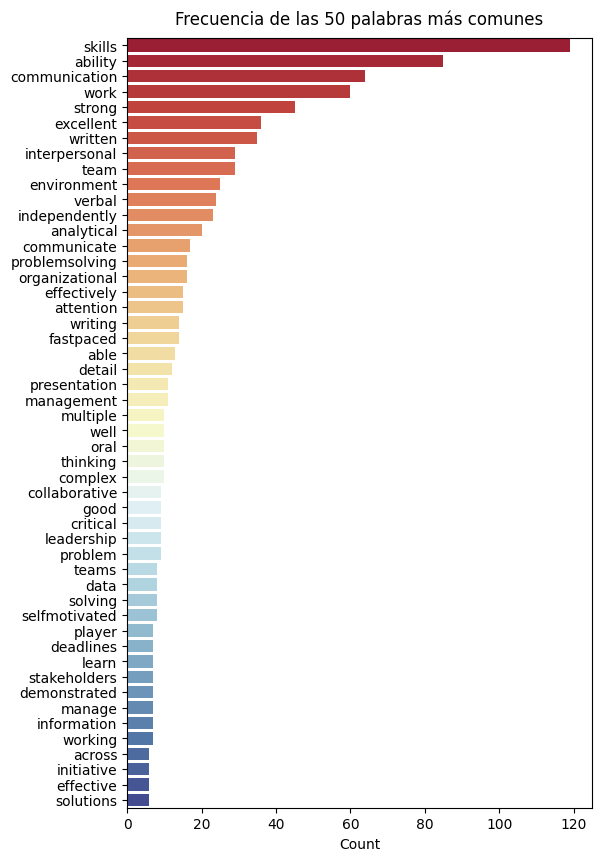

In [49]:
most_common_50 = np.array(list(map(lambda x: list(x), freq_dist.most_common(50))))

fig = plt.figure(figsize=(6, 10))
ax = fig.add_subplot()

sns.barplot(y = most_common_50[:, 0], x= [eval(i) for i in list(most_common_50[:, 1])], ax=ax, palette='RdYlBu', orient='h');
ax.set_title('Frecuencia de las 50 palabras más comunes', pad=10)
ax.set_xlabel('Count');

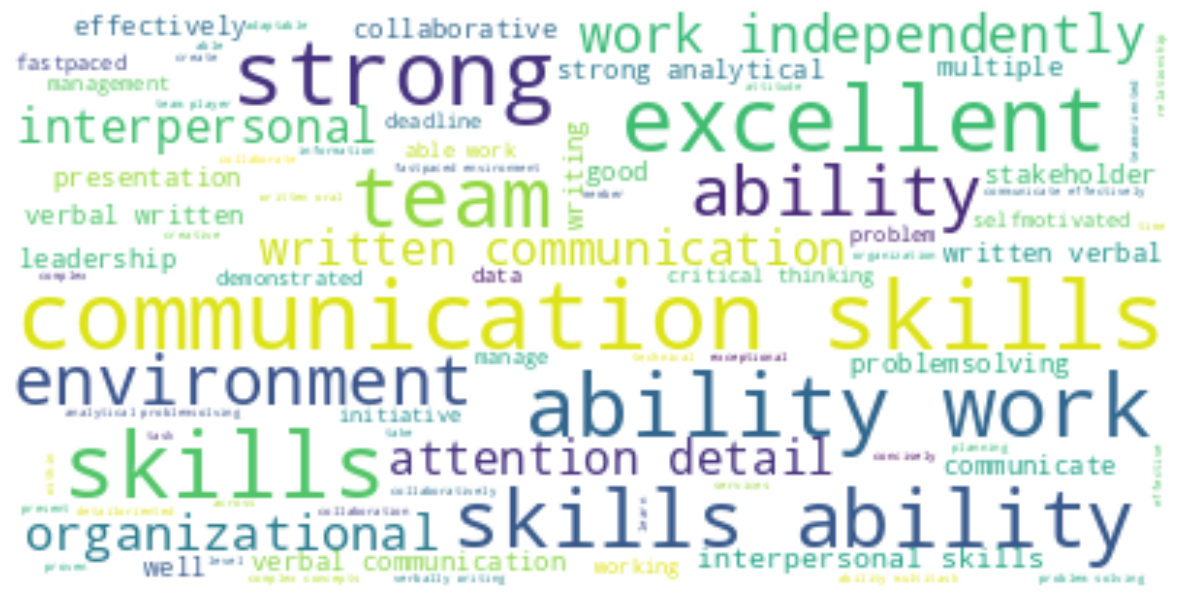

In [50]:
wordcloud = WordCloud(max_font_size=100, background_color="white").generate(' '.join(all_words_except_stop_words))

plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Ajustamos los nuevos términos relevantes:

+ skills
+ ability
+ comunication
+ work
+ strong
+ written
+ interpresonal
+ team
+ verbal
+ independently

In [51]:
Desc_laborales = X_train["Descripción"][X_train["Descripción"] != "not specified"].copy()

#Hacemos limpieza previa del texto:
Desc_laborales = Desc_laborales.str.replace(",|\.|\;|\:|\+|·", " ", regex=True)
Desc_laborales = Desc_laborales.str.lower()
Desc_laborales = Desc_laborales.str.strip()
Desc_laborales = Desc_laborales.str.replace('[^\w\s]', '')
Desc_laborales = Desc_laborales.str.replace('\d', '')
Desc_laborales = Desc_laborales.str.replace('\\n', '')
Desc_laborales = Desc_laborales.dropna()

In [52]:
# Separamos cada oración en palabras
tokenized = Desc_laborales.apply(nltk.word_tokenize)
# Sumamos todas las listas para obtener una lista con todas las palabras en nuestro conjunto de datos
all_words = tokenized.sum()
text = nltk.Text(all_words)

In [53]:
all_words = tokenized.sum()
english_stop_words = stopwords.words('english')
spanish_stop_words = stopwords.words('spanish')
all_words_except_stop_words = [word for word in all_words if word not in english_stop_words]
all_words_except_stop_words = [word for word in all_words_except_stop_words if word not in spanish_stop_words]
freq_dist = nltk.FreqDist(all_words_except_stop_words)

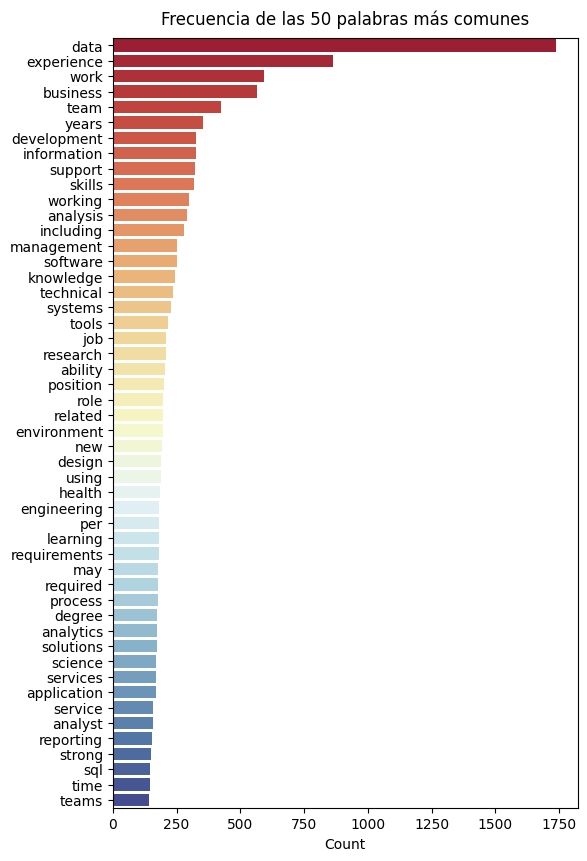

In [54]:
most_common_50 = np.array(list(map(lambda x: list(x), freq_dist.most_common(50))))

fig = plt.figure(figsize=(6, 10))
ax = fig.add_subplot()

sns.barplot(y = most_common_50[:, 0], x= [eval(i) for i in list(most_common_50[:, 1])], ax=ax, palette='RdYlBu', orient='h');
ax.set_title('Frecuencia de las 50 palabras más comunes', pad=10)
ax.set_xlabel('Count');

In [55]:
#most_common_50[0:17]

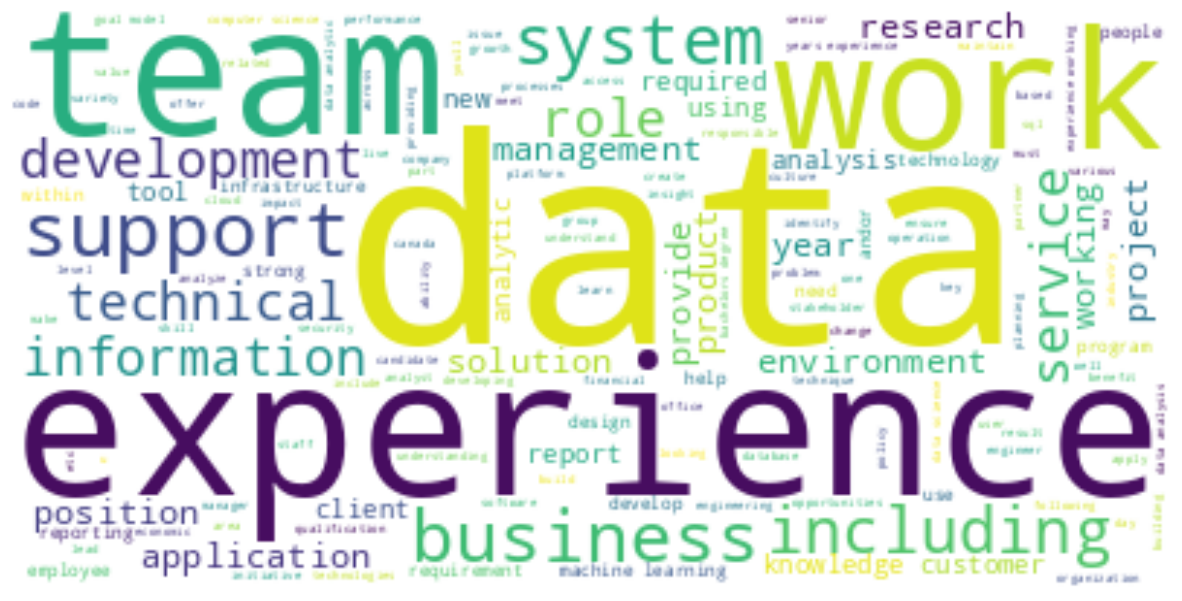

In [56]:
wordcloud = WordCloud(max_font_size=100, background_color="white").generate(' '.join(all_words_except_stop_words))

plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Gracias a lo anterior, sabemos que en nuestros datos de entrenamiento tenemos una gran presencia de las siguientes palabras de la descripción:

+ data
+ experience
+ work
+ business
+ team
+ years
+ development
+ information
+ support
+ analysis

Ahora, solo modificamos la función pertinente a las habilidades blandas y la variable de la descripción

In [57]:
""" Función para obtener los términos más importantes para las habilidades blandas y la descripción
"""
def most_words_description(data_original):
    data = data_original.copy()
    description_dict = {"data" : "data/datos",
                        "experience" : "experience/experiencia",
                        "work" : "work/working",
                        "business" : "business",
                        "team" : "team",
                        "years" : "tiempo/años/years",
                        "development" : "development/desarollo",
                        "information" : "información/information",
                        "support" : "support",
                        "analysis": "análisis/analista"}
    blandas_dict = {"skills" : "skills",
                    "ability" : "ability/habilidades",
                    "communication" : "communication/comunicación",
                    "work" : "work/trabajo",
                    "strong" : "strong",
                    "written" : "written",
                    "interpresonal" : "interpresonal",
                    "team" : "team/equipo",
                    "verbal" : "verbal/oral",
                    "independently" : "independently"}

#Creamos las variables
    for i in list(set(description_dict.values())):
        data[i] = 0
    for i in list(set(blandas_dict.values())):
        data[i] = 0
        
    #Ahora, hacemos las identificaciones:
    for i in description_dict.keys():
        data[description_dict[i]] = data[description_dict[i]] + data["Descripción"].map(lambda x: bool(re.search(i,check_string(x))))
    for i in blandas_dict.keys():
        data[blandas_dict[i]] = data[blandas_dict[i]] + data["Habilidades blandas"].map(lambda x: bool(re.search(i,check_string(x))))

    for i in list(set(description_dict.values())):
        data[i] = data[i].map(lambda x: 1 if x > 1 else x)
    for i in list(set(blandas_dict.values())):
        data[i] = data[i].map(lambda x: 1 if x > 1 else x)
    
    return data

Y ahora, aplicamos las anteriores trasnformaciones a nuestros conjuntos de datos

In [58]:
X_train = dummy_lenguageProgramming(X_train)
X_train = dummy_school(X_train)

X_test = dummy_lenguageProgramming(X_test)
X_test = dummy_school(X_test)

In [59]:
X_train = most_words_description(X_train)

X_test = most_words_description(X_test)

In [60]:
X_train.drop(["Puesto laboral", "Empresa", "Salario mínimo", "Salario máximo", "Descripción","Fecha de publicación","Vigencia de la oferta", "Estudios previos" ,"Habilidades blandas", "Lenguajes de programación/tecnologías requeridas"], axis = 1, inplace=True)
#Eliminamos la variable `Giro de la empresa` ya que en pasos posteriores, la agrupación de categorías relevantes hacía que esta variable no diera información importante. 
X_train.drop(["Giro de la empresa"], inplace=True, axis = 1)

In [61]:
X_train = X_train.fillna(value = {"Experiencia (Años) ":X_train["Experiencia (Años) "].mean()})
X_test = X_test.fillna(value = {"Experiencia (Años) ":X_test["Experiencia (Años) "].mean()})

In [62]:
X_train = normalize(X_train, cat_cols)
X_test = normalize(X_test, cat_cols)

Nuestra identificación de outliers indica que solo un 5% de los registros son considerados como tal

In [63]:
Xq = pd.concat(map(lambda column: detect_outlier(X_train[column], "iqr").rename(f"{column}_ol"), X_train[num_cols].columns), axis=1)
shape_old = X_train.shape
shape_new_qr = Xq[Xq.mean(axis=1)<=.4].shape
print(shape_new_qr[0]/shape_old[0])

0.9563106796116505


Así que removemos dichos valores extremos

In [64]:
out_index = Xq[Xq.mean(axis=1)>0.4].index
X_train = X_train[[i not in out_index for i in X_train.index]]
y_train = y_train[[i not in out_index for i in y_train.index]]

Mismo caso: gran cantidad de lenguajes o software que se solicita en la oferta laboral o por solicitar una gran cantidad de años de experiencia

In [65]:
jobs.iloc[list(out_index)]

,Puesto laboral,Empresa,Estado,Ciudad,Salario mínimo,Salario máximo,Tipo de moneda,Descripción,Giro de la empresa,Fecha de publicación,Vigencia de la oferta,País,Esquema de pago,Cantidad de lenguajes requeridos,Título ofrecido,Requerimiento educación,Salario promedio,Lenguajes de programación/tecnologías requeridas,Modalidad,Estudios previos,Experiencia (Años),Habilidades blandas,Idiomas
215,Analista de Bases de Datos,TRES R,México,not specified,750.0000,NaN,MXN,Esta vacante viene de la bolsa de empleo Talen...,not specified,2022-09-05,2022-10-15,MX,month,1,Not specified,1,750.0000,excel,presencial,"matemáticas, administración, economía, finanza...",1.0000,aptitudes analíticas y numéricas desarrolladas,Español
0,Data Engineer with Azure Synapse,4urHires INC,remoto,not specified,8800.0000,9600.0000,USD,Azure Engineer Strong experience in SynapseJob...,not specified,2022-09-16,2022-10-16,EUA,hour,2,Not specified,1,9200.0000,"azure,synapse",remoto,"azure engeneer,",10.0000,not specified,Inglés
3,Entry-Level Azure Data Engineer,"Antra, Inc",remoto,not specified,5166.6667,5833.3333,USD,"About usAntra, Inc is a leading IT consultancy...",Tecnologías de la información,2022-09-13,2022-10-16,EUA,year,18,Junior,1,5500.0000,"sql,python,scala,r,sql server,oracle,mysql,no ...",remoto,"minimum bachelor’s degree in data science, bus...",0.0000,"excellent problem-solving skills, ability to ...",Inglés
4,Data Engineer only for OPT EAD,CloudBig Technology,remoto,not specified,8000.0000,9600.0000,USD,Work with Technical and business team to under...,not specified,2022-09-15,2022-10-16,EUA,hour,2,Not specified,1,8800.0000,"sql,data warehouse",remoto,master's,11.0000,"work with other,",Inglés
226,Analista de Finanzas (CxC),OGGI JEANS,México,not specified,500.0000,650.0000,MXN,Importante Empresa de Jeans solicita:Analista ...,not specified,2022-08-31,2022-10-15,MX,month,2,Not specified,1,575.0000,"microsoft office,excel",not specified,"pasante de contabilidad, finanzas, administrac...",2.0000,"responsabilidad, honestidad, comunicación efec...",Español
233,Analista de Datos - Experto en Excel,HUMAN RS,México,not specified,1400.0000,1500.0000,MXN,IMPORTANTE LABORATORIO FARMACÉUTICA SE ENCUENT...,not specified,2022-08-30,2022-10-15,MX,month,1,Not specified,1,1450.0000,excel,not specified,"lic. admi, ing. industrial, ing sistemas, info...",2.0000,not specified,Inglés avanzado/bilingüe
9,ETL Data Engineer || REMOTE || Contract Role,Valsatech Corp,remoto,not specified,9600.0000,11200.0000,USD,HiThis is regarding to a position of an ETL Da...,not specified,2022-09-07,2022-10-16,EUA,hour,5,Not specified,1,10400.0000,"oracle,sql server,teradata,unix,shell",remoto,"graduate degree in computer science, statistic...",12.0000,"lead, mentor, excellent interpersonal, verbal,...",Inglés
26,Machine Learning Engineer [Remote],Braintrust,remoto,San Francisco,20000.0000,23200.0000,USD,ABOUT US:\n\nBraintrust is the only network th...,Administración y consultoría,2022-09-13,2022-10-16,EUA,hour,15,Not specified,1,21600.0000,"spark,aws sagemaker,apache airflow,databricks,...",remoto,degree with strong technical focus (computer s...,4.0000,not specified,Inglés
252,Ingeniero de datos o científico de datos,PROESA ELTEC,México,not specified,750.0000,1250.0000,MXN,Ingeniero de datos o científico de datos. Ing....,not specified,2022-09-07,2022-10-14,MX,month,4,Not specified,1,1000.0000,"appian,java,sql,python",presencial,"ing. en computacion, informática o afin.desarr...",NaN,not specified,Inglés avanzado/bilingüe


In [66]:
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler(with_mean=False))]
)

categorical_transformer = OneHotEncoder(handle_unknown='infrequent_if_exist', sparse=False)

preprocessor = ColumnTransformer(verbose=2,
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ], remainder="passthrough"
)

In [67]:
param_grid_tree = {
    'n_estimators' : [10, 50, 100],
    'min_samples_split' : [5, 10, 15, 20],
    'min_samples_leaf' : [2, 5, 7, 10],
}

param_grid_poly = {
    'degree' : [2, 3, 4, 5],
}

lr_model = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())]
)

pl_model = Pipeline(
    steps=[("preprocessor", preprocessor), ("Poly", RandomizedSearchCV(PolynomialFeatures(), 
                                                                           param_grid_poly, n_iter=7,scoring="neg_mean_squared_error",
                                                                           cv = 4, verbose=2)),
          ("regressor", LinearRegression())]
)

dt_model = Pipeline(
    steps = [("preprocessor", preprocessor), ('regressor', RandomizedSearchCV(RandomForestRegressor(), 
                                                                              param_grid_tree, n_iter=7,scoring="neg_mean_squared_error",
                                                                              cv=4, verbose=2))]
)

Aplicación de modelos

In [68]:
X_train["Cantidad de lenguajes requeridos"] = X_train["Cantidad de lenguajes requeridos"].astype(str)
X_train["Experiencia (Años) "] = X_train["Experiencia (Años) "].astype(str)

X_test["Cantidad de lenguajes requeridos"] = X_test["Cantidad de lenguajes requeridos"].astype(str)
X_test["Experiencia (Años) "] = X_test["Experiencia (Años) "].astype(str)

lr_model.fit(X_train, y_train.map(np.log))
pl_model.fit(X_train, y_train.map(np.log))
dt_model.fit(X_train, y_train.map(np.log))

[ColumnTransformer] ........... (1 of 3) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 3) Processing cat, total=   0.0s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s
[ColumnTransformer] ........... (1 of 3) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 3) Processing cat, total=   0.0s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s
Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV] END ...........................................degree=2; total time=   0.0s
[CV] END ...........................................degree=2; total time=   0.0s
[CV] END ...........................................degree=2; total time=   0.0s
[CV] END ...........................................degree=2; total time=   0.0s
[CV] END ...........................................degree=3; total time=   0.0s
[CV] END ...........................................degree=3; total time=   0.0s
[CV] END ...................

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['Cantidad de lenguajes '
                                                   'requeridos',
                                                   'Experiencia (Años) ']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                sparse=False),
                                                  ['Estado', 'Tipo de moneda',
                                                   'Ciudad', 'Idiomas',
                                                   'Título ofrecido', 'País',
                                                   'Esquema de pago',
                                                   'Modalidad'])],
                                   verbose=2)),
                ('regressor',
                 RandomizedSearchCV(cv=4, estimator=RandomForestRegressor(),
                                    n_iter=7,
                                    param_distributions={'min_samples_leaf': [2,
                                                                              5,
                                                                              7,
                                                                              10],
                                                         'min_samples_split': [5,
                                                                               10,
                                                                               15,
                                                                               20],
                                                         'n_estimators': [10,
                                                                          50,
                                                                          100]},
                                    scoring='neg_mean_squared_error',
                                    verbose=2))])

y evaluamos nuestros modelos:

In [69]:
y_test_predict_lr = lr_model.predict(X_test)
MSE = mean_squared_error(y_test.map(np.log),y_test_predict_lr)
print("Entrenamiento: MSE linear ="+str(MSE))

y_test_predict_pl = pl_model.predict(X_test)
MSE = mean_squared_error(y_test.map(np.log),y_test_predict_pl)
print("Entrenamiento: MSE poly ="+str(MSE))

y_test_predict_tr = dt_model.predict(X_test)
MSE = mean_squared_error(y_test.map(np.log),y_test_predict_tr)
print("Entrenamiento: MSE tree ="+str(MSE))

Entrenamiento: MSE linear =0.30569373688292
Entrenamiento: MSE poly =0.3504326802085011
Entrenamiento: MSE tree =0.17161145635040279


Nuevamente, el arbol de decisión es el ganador respecto a los otros modelos.

Ahora, realizamos lo mismo identificando las variables más relevantes

In [70]:
pdf = preprocessor.fit(X_train)
Xt_skb = pd.DataFrame(pdf.transform(X_train), columns=pdf.get_feature_names_out())
kb = SelectKBest(k="all", score_func = f_regression)
kb.fit(X=Xt_skb, y=y_train.map(np.log))
df_scores = pd.DataFrame(data=zip(kb.get_feature_names_out(), kb.scores_, kb.pvalues_), columns=["feature", "score", "pvalues"])
df_scores.sort_values(by="score", ascending=False).reset_index()

[ColumnTransformer] ........... (1 of 3) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 3) Processing cat, total=   0.0s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s


,index,feature,score,pvalues
0,10,cat__Tipo de moneda_USD,18.7784,0.0000
1,20,cat__País_CAN,15.4166,0.0001
2,8,cat__Tipo de moneda_CAD,15.4166,0.0001
3,21,cat__País_EUA,15.4166,0.0001
4,24,cat__Esquema de pago_not specified,7.7686,0.0058
5,2,cat__Estado_Alberta,7.2094,0.0079
6,9,cat__Tipo de moneda_Others,5.8706,0.0163
7,23,cat__Esquema de pago_hour,5.4670,0.0204
8,61,remainder__matemáticas,4.4839,0.0355
9,57,remainder__computación,4.2088,0.0416


Vamos a considerar solo aquellas variables que consiguen un p-value significativo y replicar los modelos anteriores para ver el performance que estos tienen considerando ahora menos variables

In [71]:
ls_best = df_scores.sort_values(by="score", ascending=False).head(11)["feature"]

In [72]:
lr_model_skb = Pipeline(verbose=2,
    steps=[("preprocessor", preprocessor), 
           ("selector", ColumnTransformer([
               ("selector", "passthrough", ls_best.index)], remainder="drop")),
           ("regressor", LinearRegression())]
)

pl_model_skb = Pipeline(verbose=2,
    steps=[("preprocessor", preprocessor), 
           ("selector", ColumnTransformer([
               ("selector", "passthrough", ls_best.index)], remainder="drop")),
           ("Poly", RandomizedSearchCV(PolynomialFeatures(), 
                                                                           param_grid_poly, n_iter=7,scoring="neg_mean_squared_error",
                                                                           cv = 4, verbose=2)),
          ("regressor", LinearRegression())]
)

dt_model_skb = Pipeline(verbose=2,
    steps=[("preprocessor", preprocessor), 
           ("selector", ColumnTransformer([
               ("selector", "passthrough", ls_best.index)], remainder="drop")),
           ('regressor', RandomizedSearchCV(RandomForestRegressor(), 
                                                                              param_grid_tree, n_iter=7,scoring="neg_mean_squared_error",
                                                                              cv=4, verbose=2))]
)

lr_model_skb.fit(X_train, y_train.map(np.log))
pl_model_skb.fit(X_train, y_train.map(np.log))
dt_model_skb.fit(X_train, y_train.map(np.log))

y_test_predict_lr = lr_model_skb.predict(X_test)
MSE = mean_squared_error(y_test.map(np.log),y_test_predict_lr)
print("Entrenamiento: MSE linear ="+str(MSE))

y_test_predict_pl = pl_model_skb.predict(X_test)
MSE = mean_squared_error(y_test.map(np.log),y_test_predict_pl)
print("Entrenamiento: MSE poly ="+str(MSE))

y_test_predict_tr = dt_model_skb.predict(X_test)
MSE = mean_squared_error(y_test.map(np.log),y_test_predict_tr)
print("Entrenamiento: MSE tree ="+str(MSE))

[ColumnTransformer] ........... (1 of 3) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 3) Processing cat, total=   0.0s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s
[Pipeline] ...... (step 1 of 3) Processing preprocessor, total=   0.0s
[Pipeline] .......... (step 2 of 3) Processing selector, total=   0.0s
[Pipeline] ......... (step 3 of 3) Processing regressor, total=   0.0s
[ColumnTransformer] ........... (1 of 3) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 3) Processing cat, total=   0.0s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s
[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=   0.0s
[Pipeline] .......... (step 2 of 4) Processing selector, total=   0.0s
Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV] END ...........................................degree=2; total time=   0.0s
[CV] END ...........................................degree=2; total time=   0.

Véase que nuestro rendimiento en el árbol de decisión no varía mucho comparado al modelo donde se utilizan todas las variables.

Ya que tenemos nuestro modelo, podemos ver las variables más importantes que tienen un efecto mayor sobre el salario promedio ofrecido

In [73]:
sorted_idx = dt_model.named_steps["regressor"].best_estimator_.feature_importances_.argsort()
features = Xt_skb.columns[sorted_idx]
importance = (dt_model.named_steps["regressor"].best_estimator_.feature_importances_)[sorted_idx]
for i in range(len(features)):
    print(features[i], ": ", importance[i])

remainder__sas :  0.0
remainder__física :  0.0
remainder__tableau :  0.0
remainder__r :  0.0
remainder__oracle :  0.0
remainder__spark :  0.0
remainder__hadoop :  0.0
cat__Modalidad_Others :  0.0
remainder__google :  0.0
remainder__azure :  0.0
remainder__javascript :  0.0
remainder__carrera trunca/bachillerato :  0.0
remainder__doctorado/postdoctorado :  0.0
remainder__biology/bioinformatics/etc. :  0.0
remainder__actuaría :  0.0
remainder__aws :  0.0
remainder__ciencia/ingienería de datos :  0.0
remainder__finanzas :  0.0
remainder__interpresonal :  0.0
cat__Tipo de moneda_Others :  0.0
cat__Idiomas_Others :  0.0
cat__Idiomas_Inglés :  0.0
remainder__apache :  0.0003123741948347078
cat__Estado_British Columbia :  0.00033313795185567344
cat__Estado_remoto :  0.0006345684001454915
remainder__java :  0.0008164316183874093
remainder__maestría :  0.0009309947492257883
cat__Modalidad_presencial :  0.0010048837864272144
remainder__c/c#/c++ :  0.0013029429130822462
remainder__ability/habilid

# Conclusiones

+ 1. Analizando el salario promedio, el comportamiento de esta variable muestra dos modas, por lo que los resultados de los modelos podrían no ser los adecuados. Por esta razón, se decidió hacer modelos independientes con las poblaciones de Estados Unidos / Canada y México por separado lo cual resulto beneficioso.

+ 2. Con los distintos modelos utilizados, el arbol de decisión aplicado a nuestro problema de regresión mostró tener los mejores resultados con un buen desempeño, además de los beneficios que tiene un árbol de decisión sobre los otros algoritmos (beneficios visuales y costo computacional)

+ 3. En el caso de México, los factores que tienen una mayor importancia al momento de establecer el salario promedio son los años de experiencia, la cantidad de lenguajes de programación o herramientas computaciones, en especial excel/vba, nivel de estudios, siendo las carreras más solicitadas: actuaría, ingeniería y matemáticas, seguido por la modalidad de trabajo (remoto o presencial) y tener un nivel intermedio de inglés. Las empresas, valoran mucho un pensamiento analítico, el trabajo en equipo y habilidades de comunicación escritas y orales. Y las herramientas de programación más relevantes en el mercado mexicano, después de excel/vba, son azure, python y sql.

+ 4. En constraste con Estados Unidos y Canada, el dominio de una mayor cantidad lenguajes de programación o herramientas computaciones tiene un mayor relevancia que el número de años de experiencia, aunque esta sigue siendo un factor muy importante para el mercado. Otro punto relevante es que, en estos países, el requerimiento sobre algún de tipo de educación, como la licenciatura, no tiene una importancia más grande que tener las habilidades suficientes para el empleo. Conocimientos relacionados a la computación, seguido de la economía y matemáticas son los más valorados en este mercado y las herramientas de programación más relevantes son microsoft office, power bi, sql. Respecto a las habilidades blandas, la más solicitada son las habilidades de comunicación oral.